In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

# Load processed dataset
data_path = "../data/processed_dataset.csv"
df = pd.read_csv(data_path)

# Display the first few rows
df.head()


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,day,weekday,hour
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,1,4,6,0
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,4,6,2
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,4,6,3
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,1,4,6,4


In [5]:
# User-defined parameters
rand_state = 42  # Random seed
cv_num = 5       # Number of folds in cross-validation

# Define target and features
target = "cnt"
features = [col for col in df.columns if col != target]

# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Display the shape of the datasets
print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set: X_test={X_test.shape}, y_test={y_test.shape}")

Training set: X_train=(13931, 12), y_train=(13931,)
Testing set: X_test=(3483, 12), y_test=(3483,)


In [6]:
# Define models with default hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1, random_state=rand_state),
    'Lasso': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.7),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=rand_state),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=rand_state),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=rand_state),
    'SVR (RBF Kernel)': SVR(kernel='rbf', C=100, gamma='scale'),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=rand_state)
}

In [7]:
# Function to evaluate models using cross-validation
def evaluate_model(model, X, y):
    cv = KFold(n_splits=cv_num, shuffle=True, random_state=rand_state)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    return -scores.mean()  # Return the mean negative RMSE


In [5]:
# Evaluate models
results = {}
for name, model in models.items():
    rmse = evaluate_model(model, X_train, y_train)
    results[name] = rmse

# Display results
print("Model performance (RMSE):")
for name, score in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name}: RMSE = {score:.4f}")

Model performance (RMSE):
Random Forest: RMSE = 265.1284
Gradient Boosting: RMSE = 372.4465
XGBoost: RMSE = 372.8290
Decision Tree: RMSE = 625.2938
SVR (RBF Kernel): RMSE = 841.9162
Lasso: RMSE = 901.4076
Ridge: RMSE = 901.4079
Linear Regression: RMSE = 901.4084
Elastic Net: RMSE = 901.8864


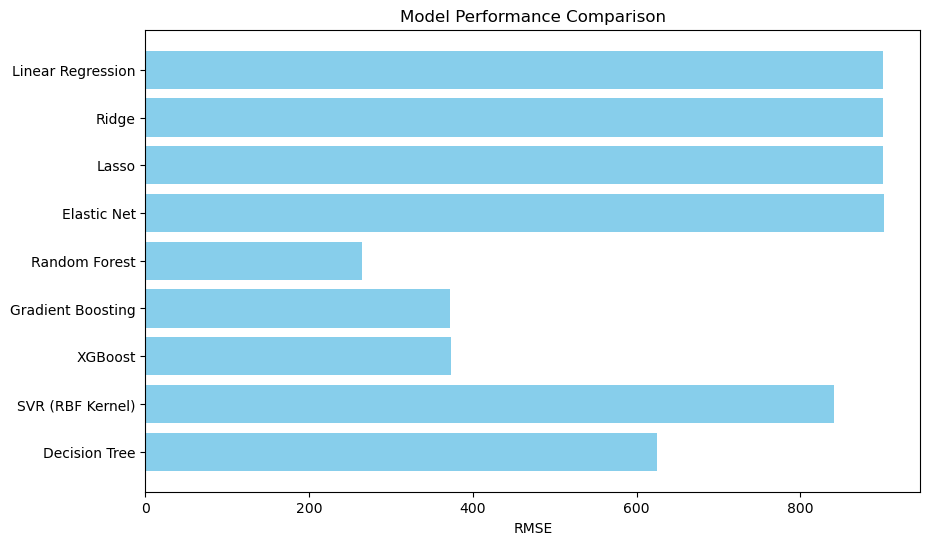

In [6]:
# Plot model performance
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
rmse_scores = list(results.values())
plt.barh(model_names, rmse_scores, color='skyblue')
plt.xlabel("RMSE")
plt.title("Model Performance Comparison")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [7]:
# Select top 3 models
top_models = sorted(results.items(), key=lambda x: x[1])[:3]
print("Top 3 models:")
for name, score in top_models:
    print(f"{name}: RMSE = {score:.4f}")


Top 3 models:
Random Forest: RMSE = 265.1284
Gradient Boosting: RMSE = 372.4465
XGBoost: RMSE = 372.8290


# Hyperparametrisation for Random Forest

In [9]:
# Define Random Forest model
random_forest = RandomForestRegressor(random_state=42)

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search for Random Forest
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=cv, verbose=1)

# Perform grid search
grid_search_rf.fit(X_train, y_train)

# Best model and metrics
best_rf = grid_search_rf.best_estimator_
print("------- Random Forest - Hyperparameters Grid Search results ---------\n")
print("The best score (RMSE):", -grid_search_rf.best_score_)
print("The best parameters:", grid_search_rf.best_params_)
print("\n-----------------------------\n")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
------- Random Forest - Hyperparameters Grid Search results ---------

The best score (RMSE): 220.9873420933357
The best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

-----------------------------



# Hyperparametrization for Gradient Boosting

In [12]:
# Define Gradient Boosting model
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# Grid search for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid_gb, scoring='neg_root_mean_squared_error', cv=cv, verbose=1)

# Perform grid search
grid_search_gb.fit(X_train, y_train)

# Best model and metrics
best_gb = grid_search_gb.best_estimator_
print("------- Gradient Boosting - Hyperparameters Grid Search results ---------\n")
print("The best score (RMSE):", -grid_search_gb.best_score_)
print("The best parameters:", grid_search_gb.best_params_)
print("\n-----------------------------\n")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
------- Gradient Boosting - Hyperparameters Grid Search results ---------

The best score (RMSE): 199.38665659904626
The best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}

-----------------------------



# Hyperparametrization for XGBoost

In [10]:
# Define XGBoost model
xgboost = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0]
}

# Grid search for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, scoring='neg_root_mean_squared_error', cv=cv, verbose=1)

# Perform grid search
grid_search_xgb.fit(X_train, y_train)

# Best model and metrics
best_xgb = grid_search_xgb.best_estimator_
print("------- XGBoost - Hyperparameters Grid Search results ---------\n")
print("The best score (RMSE):", -grid_search_xgb.best_score_)
print("The best parameters:", grid_search_xgb.best_params_)
print("\n-----------------------------\n")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
------- XGBoost - Hyperparameters Grid Search results ---------

The best score (RMSE): 183.75626126053368
The best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

-----------------------------



# Comparison

In [12]:
# Test data predictions for best models
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Metrics for each model
def evaluate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    explained_variance = explained_variance_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R²): {r2:.2f}")
    print(f"Explained Variance Score: {explained_variance:.2f}")
    print()

evaluate_metrics(y_test, y_pred_rf, "Random Forest")
evaluate_metrics(y_test, y_pred_gb, "Gradient Boosting")
evaluate_metrics(y_test, y_pred_xgb, "XGBoost")


--- Random Forest ---
Mean Squared Error (MSE): 46332.02
Root Mean Squared Error (RMSE): 215.25
Mean Absolute Error (MAE): 116.36
R-squared (R²): 0.96
Explained Variance Score: 0.96

--- Gradient Boosting ---
Mean Squared Error (MSE): 35708.23
Root Mean Squared Error (RMSE): 188.97
Mean Absolute Error (MAE): 101.75
R-squared (R²): 0.97
Explained Variance Score: 0.97

--- XGBoost ---
Mean Squared Error (MSE): 31164.10
Root Mean Squared Error (RMSE): 176.53
Mean Absolute Error (MAE): 96.12
R-squared (R²): 0.97
Explained Variance Score: 0.97



# Feature Importance for RF and XGBoost

In [13]:
# Feature importance for Random Forest
rf_importances = best_rf.feature_importances_
rf_features = {feature: importance for feature, importance in zip(features, rf_importances)}

print("\nFeature Importances - Random Forest:")
for feature, importance in sorted(rf_features.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

# Feature importance for XGBoost
xgb_importances = best_xgb.feature_importances_
xgb_features = {feature: importance for feature, importance in zip(features, xgb_importances)}

print("\nFeature Importances - XGBoost:")
for feature, importance in sorted(xgb_features.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")



Feature Importances - Random Forest:
hour: 0.7147
t2: 0.0465
weekday: 0.0451
t1: 0.0443
is_weekend: 0.0378
hum: 0.0371
is_holiday: 0.0204
weather_code: 0.0165
day: 0.0121
wind_speed: 0.0093
month: 0.0087
season: 0.0074

Feature Importances - XGBoost:
hour: 0.3614
is_weekend: 0.2733
is_holiday: 0.2158
t1: 0.0311
season: 0.0251
weather_code: 0.0247
hum: 0.0157
t2: 0.0144
month: 0.0138
weekday: 0.0118
day: 0.0086
wind_speed: 0.0043


# Save best model

In [11]:
import pickle

# Save the trained model
with open("../models/xgboost_model.pkl", "wb") as file:
    pickle.dump(best_xgb, file)

print("Model saved using pickle.")

Model saved using pickle.
